# Imports

In [1]:
import sys
import random
import numpy as np

import gym
from gym import error, spaces, utils
from gym.utils import seeding

import time

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

from keras import backend as K
import tensorflow as tf

import math

# Create Gin Rummy Environment

In [2]:
class Deck:

    def __init__(self):

        deckofcards = np.arange(52)

        np.random.shuffle(deckofcards)

        deck_list = deckofcards.tolist()

        self.deckofcards = deck_list


    def draw_card(self):

        return self.deckofcards.pop(0)


    def deal_hand(self):

        hand_size = 10
        hand = []

        for i in range(hand_size):
            hand.append(self.deckofcards.pop(0))

        return hand

    
    def add_to_deck(self, card):

        self.deckofcards.append(card)
        np.random.shuffle(self.deckofcards)

In [3]:
class DiscardBoard():

    def __init__(self):

        self.discarded = []


    def add_to_board(self, discarded_card):

        self.discarded.append(discarded_card)


    def remove_from_board(self, discarded_card):

        self.discarded.remove(discarded_card)


    def discarded_cards_exist(self):

        return (len(self.discarded) > 0)

In [4]:
class PlayerBoard():

    def __init__(self, initial_hand):

        self.hand = initial_hand[:]


    def add_card(self, card):

        self.hand.append(card)


    def discard_card(self, card):

        self.hand.remove(card)
        

    def card_exists(self, card):

        return (card in self.hand)

In [5]:
def inital_discard(deck, discard_board):

    new_card = deck.draw_card()
    discard_board.add_to_board(new_card)

    return new_card


def draw_deck_card(player_board, deck):

    new_card = deck.draw_card()
    player_board.add_card(new_card)

    return new_card


def draw_discarded_card(player_board, discard_board, discard):

    discard_board.remove_from_board(discard)
    player_board.add_card(discard)
    

def discard_hand_card(player_board, discard_board, card):

    discard_board.add_to_board(card)
    player_board.discard_card(card)

In [6]:
def find_sets(player_hand):

    num_sets = 0
    four_card_set = False

    map_card_num = {}

    for hand_card in player_hand:

        card_value = int(hand_card % 13)

        if card_value in map_card_num.keys():

            number_card_updated = map_card_num.get(card_value) + 1
            map_hand_card = {card_value : number_card_updated}
            map_card_num.update(map_hand_card)

            if map_card_num.get(card_value) == 3:

                num_sets += 1

            if map_card_num.get(card_value) == 4:

                four_card_set = True

        else:

            map_card_num[card_value] = 1

    return num_sets, four_card_set


def find_runs(player_hand):

    sorted_hand = player_hand[:]
    sorted_hand.sort()

    num_runs = 0
    card_runs = []
    cards_in_run = []
    four_card_run = False

    for hand_card in range(len(sorted_hand) - 2):

        first_card = sorted_hand[hand_card]
        second_card = sorted_hand[hand_card + 1]
        third_card = sorted_hand[hand_card + 2]

        if first_card in cards_in_run or second_card in cards_in_run or third_card in cards_in_run:

            continue

        if (first_card + 1) == second_card and (first_card + 2) == third_card:

            num_runs += 1

            if not four_card_run and (hand_card + 3) < len(sorted_hand) and (first_card + 3) == sorted_hand[hand_card + 3]:

                fourth_card = sorted_hand[hand_card + 3]

                card_runs.append([first_card, second_card, third_card, fourth_card])

                cards_in_run.append(first_card)
                cards_in_run.append(second_card)
                cards_in_run.append(third_card)
                cards_in_run.append(fourth_card)

                four_card_run = True
            
            else:

                card_runs.append([first_card, second_card, third_card])

                cards_in_run.append(first_card)
                cards_in_run.append(second_card)
                cards_in_run.append(third_card)

    return num_runs, card_runs, cards_in_run, four_card_run


def check_victory(player_hand):

    player_hand_copy = player_hand[:]
    num_runs, card_runs, cards_in_run, four_card_run = find_runs(player_hand_copy)

    updated_hand = [cards for cards in player_hand if cards not in cards_in_run]
    num_sets, four_card_set = find_sets(updated_hand)

    four_combination = four_card_set or four_card_run

    return (four_combination and (num_sets + num_runs) >= 3)


def calculate_score(player_board):

    score = 0

    player_hand = player_board.hand[:]
    num_sets, four_card_set = find_sets(player_hand)
    num_runs, card_runs, cards_in_run, four_card_run = find_runs(player_hand)

    # each additinal set/run is worth more than the set/run before it as 
    # it becomes harder to make those combinations and greatly imporves 
    # the chace of the player to win

    for i in range(num_sets):

        score += pow(10, i+1)

    for j in range(num_runs):

        score += pow(10, num_sets+j+1)

    if four_card_set or four_card_run:

        score += 1000

    if check_victory(player_hand):

        score += 1000000000

    return score

In [7]:
class GameBoard():

    def __init__(self):

        # 52 inital cards, 10 cards for each hand, 1 top discard
        self.cards_remaining = 52 - 21
        self.moves_made = 0

        self.deck = Deck()

        self.p1_board = PlayerBoard(self.deck.deal_hand())
        self.p2_board = PlayerBoard(self.deck.deal_hand())

        self.discard_board = DiscardBoard()


    def report_score(self, player):

        if (player == 1):

            player_board = self.p1_board

        else:

            player_board = self.p2_board

        return calculate_score(player_board)

In [8]:
def pack_action(action, card, discard):

    return (action, card, discard)


def unpack_action(pack_action):

    action = pack_action[0]
    card = pack_action[1]
    discard = pack_action[2]

    return action, card, discard

In [9]:
def make_move(action, card, discard, player_board, discard_board, deck):

    # action = 1 -- draw from deck
    # action = 2 -- take from discard
    if action == 1:

        drew = draw_deck_card(player_board, deck)
        
    else:

        draw_discarded_card(player_board, discard_board, card)

    player_won = check_victory(player_board.hand)
    discard_hand_card(player_board, discard_board, discard)

    return player_won

In [10]:
def get_observation(state, player):

    obs_player = np.copy(state)

    if player == 1:

        opp = 2

    else:

        opp = 1
    
    for idx in range(len(obs_player)):

        if obs_player[idx] == opp:

            obs_player[idx] = 0

    return obs_player

In [11]:
class SimplifiedGinRummyEnv(gym.Env):

    def __init__(self):

        self.__version__ = "0.0.1"

        self.gameboard = GameBoard()
        self.state = self.initialize_state()
        self.top_discard = inital_discard(self.gameboard.deck, self.gameboard.discard_board)

        # actions:
        #   draw from deck -- discard 1 of the 11 cards in hand
        #   draw from discard -- discard 1 of the other 10 cards in hand
        self.action_space = spaces.Discrete(21)
        self.observation_space = spaces.Box(low=0, high=1, shape=(52,), dtype=np.int8)


    def initialize_state(self):

        state_vec = np.zeros(52, dtype=np.int8)

        for deck_card in self.gameboard.deck.deckofcards:

            state_vec[deck_card] = 0

        for p1_hand_card in self.gameboard.p1_board.hand:

            state_vec[p1_hand_card] = 1

        for p2_hand_card in self.gameboard.p2_board.hand:

            state_vec[p2_hand_card] = 2

        for discard_card in self.gameboard.discard_board.discarded:

            state_vec[discard_card] = 3

        return state_vec


    def step(self, pack_action, player):

        finished = False

        if (player == 1):
            player_board = self.gameboard.p1_board
        else:
            player_board = self.gameboard.p2_board

        action, card, discard = unpack_action(pack_action)

        # Add back all discarded cards to deck and continue
        if self.gameboard.cards_remaining == 0 and action == 1:

            for card in self.gameboard.discard_board:

                self.gameboard.discard_board.remove_from_board(card)
                self.gameboard.deck.add_to_deck(card)
                self.gameboard.cards_remaining += 1

                self.state[card] = 0 # Add back to deck

            self.top_discard = inital_discard(self.gameboard.deck, self.gameboard.discard_board)

        finished = make_move(action, card, discard, player_board, self.gameboard.discard_board, self.gameboard.deck)
        self.gameboard.moves_made += 1

        if self.gameboard.moves_made > 150:

            finished = True

        self.top_discard = discard

        # Update state
        self.state[card] = player # 1 if p1; 2 if p2
        self.state[discard] = 3 # Add to discard pile

        if (action == 1):

            self.gameboard.cards_remaining -= 1

        reward = self.gameboard.report_score(player)

        return (reward, finished)


    def reset(self):

        self.gameboard = GameBoard()
        self.state = self.initialize_state()
        self.top_discard = inital_discard(self.gameboard.deck, self.gameboard.discard_board)

In [12]:
def find_all_valid_actions(player_board, deck, top_discard):

    hand = player_board.hand

    top_deck = None

    if len(deck.deckofcards) > 0:
    
        top_deck = deck.deckofcards[0]

    valid_actions = []

    # take from discard; will not discard taken card as it is being chosen
    for card in hand:

        valid_action = pack_action(2, top_discard, card)
        valid_actions.append(valid_action)

    if top_deck is not None:

        # draw from deck
        for card in hand:

            valid_action = pack_action(1, top_deck, card)
            valid_actions.append(valid_action)

        # can also discard the card drawn from deck
        valid_action = pack_action(1, top_deck, top_deck)
        valid_actions.append(valid_action)

    return valid_actions
    

# Create DDQN

In [13]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 512

GAMMA = 0.99
LAMBDA = 0.0001      # speed of decay

MODEL_NAME = 'ddqn_gin_rummy_v1'

## Model

In [14]:
def huber_loss(y_true, y_pred):

    HUBER_LOSS_DELTA = 1.0

    err = y_true - y_pred

    cond = K.abs(err) < HUBER_LOSS_DELTA
    L2 = 0.5 * K.square(err)
    L1 = HUBER_LOSS_DELTA * (K.abs(err) - 0.5 * HUBER_LOSS_DELTA)

    loss = tf.where(cond, L2, L1)

    return K.mean(loss)

In [15]:
class Brain:

    def __init__(self, stateCnt, actionCnt):

        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.model = self._createModel()
        self.model_ = self._createModel()


    def _createModel(self):

        model = Sequential()

        model.add(Dense(units=512, activation='relu', input_dim=self.stateCnt))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(units=self.actionCnt, activation='relu'))

        opt = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
        model.compile(loss=huber_loss, optimizer=opt)

        return model


    def train(self, x, y, epoch=1, verbose=0):

        self.model.fit(x, y, batch_size=BATCH_SIZE, epochs=epoch, verbose=verbose)


    def evaluate(self, x, y):

        return self.model.evaluate(x, y, batch_size=BATCH_SIZE, verbose=0)


    def predict(self, s, target=False):

        if target:

            return self.model_.predict(s)

        else:

            return self.model.predict(s)


    def predictOne(self, state, target=False):

        return self.predict(state.reshape(1, self.stateCnt), target).flatten()

    
    def predict_next_action(self, state, player_board, deck, top_discard, target=False):

        valid_actions = find_all_valid_actions(player_board, deck, top_discard)

        next_Qs = self.predictOne(state, target)
        idx = np.argmax(next_Qs)

        while idx not in range(len(valid_actions)):

            next_Qs = np.delete(next_Qs, idx)
            idx = np.argmax(next_Qs)

        return valid_actions[idx], idx


    def updateTargetModel(self):

        self.model_.set_weights(self.model.get_weights())

In [16]:
class Memory:   # stored as ( s, a_num, r, s_ )

    samples = []

    def __init__(self, capacity):

        self.capacity = capacity


    def add(self, sample):

        self.samples.append(sample)        

        if len(self.samples) > self.capacity:

            self.samples.pop(0)


    def sample(self, n):

        n = min(n, len(self.samples))
        return random.sample(self.samples, n)


    def isFull(self):

        return len(self.samples) >= self.capacity

In [17]:
MEMORY_CAPACITY = 200000

MAX_EPSILON = 1
MIN_EPSILON = 0.01

UPDATE_TARGET_FREQUENCY = 5
NUM_EPISODES = 100

## Agents

In [18]:
class Agent:

    def __init__(self, stateCnt, actionCnt):

        self.stateCnt = stateCnt
        self.actionCnt = actionCnt

        self.steps = 0
        self.epsilon = MAX_EPSILON

        self.brain = Brain(stateCnt, actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)

        self.rewards_log = np.zeros(NUM_EPISODES, dtype=np.int16)
        self.scores_log = np.zeros(NUM_EPISODES, dtype=np.int16)

        self.episode = 0

        
    def act(self, s, player_board, deck, top_discard):

        if random.random() < self.epsilon:

            valid_actions = find_all_valid_actions(player_board, deck, top_discard)
            random_move = random.randint(0, len(valid_actions)-1)

            return valid_actions[random_move], random_move

        else:

            return self.brain.predict_next_action(s, player_board, deck, top_discard)


    def observe(self, sample):  # in (s, a_num, r, s_) format

        self.memory.add(sample)        

        if self.steps % UPDATE_TARGET_FREQUENCY == 0:

            self.brain.updateTargetModel()

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)


    def replay(self):    

        batch = self.memory.sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = np.zeros(self.stateCnt)

        states = np.array([ o[0] for o in batch ])
        states_ = np.array([ (no_state if o[3] is None else o[3]) for o in batch ])

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_, target=False)
        pTarget_ = self.brain.predict(states_, target=True)

        x = np.zeros((batchLen, self.stateCnt))
        y = np.zeros((batchLen, self.actionCnt))
        
        for i in range(batchLen):

            o = batch[i]

            s = o[0] 
            a_num = o[1]
            r = o[2]
            s_ = o[3]
            
            t = p[i]

            if s_ is None:

                t[a_num] = r

            else:

                t[a_num] = r + GAMMA * pTarget_[i][ np.argmax(p_[i]) ]

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

In [19]:
class RandomAgent:
    
    def __init__(self, actionCnt):

        self.memory = Memory(MEMORY_CAPACITY)
        self.exp = 0


    def act(self, s, player_board, deck, top_discard):

        valid_actions = find_all_valid_actions(player_board, deck, top_discard)
        random_move = random.randint(0, len(valid_actions) - 1)

        return valid_actions[random_move], random_move
            

    def observe(self, sample):  # in (s, a_num, r, s_) format

        self.memory.add(sample)
        self.exp += 1


    def replay(self):

        pass


    def save(self):

        self.memory.tree.save()

## Training Environment

In [20]:
class Environment:

    def __init__(self):

        self.env = SimplifiedGinRummyEnv()


    def run(self, agent, logRewards=False):

        self.env.reset()
        done = False

        R = 0 

        while not done:            

            (r, done) = self.run_agent(agent)

            R += r

        if logRewards:

            agent.rewards_log[agent.episode] = R

            dqn_score = self.env.gameboard.report_score(1)
            agent.scores_log[agent.episode] = dqn_score

            print('Episode: ', agent.episode)                

            agent.episode += 1


    def run_agent(self, agent):

        rewards = [0, 0]
        done_list = [False, False]

        for i in range(2):

            player = i + 1
            state = get_observation(self.env.state, player)

            if (player == 1):

                player_board = self.env.gameboard.p1_board

            elif (player == 2):

                player_board = self.env.gameboard.p2_board

                if (done_list[0]):

                    break

            top_discard = self.env.top_discard

            s = state.copy()

            if player == 1:

                a, a_num = agent.act(state, player_board, self.env.gameboard.deck, self.env.top_discard)

            else:

                valid_actions = find_all_valid_actions(player_board, self.env.gameboard.deck, self.env.top_discard)
                a_num = random.randint(0, len(valid_actions)-1)

                a = valid_actions[a_num]

            (r, done) = self.env.step(a, player)

            if done: # terminal state

                s_ = None

            else:

                s_ = state.copy()

            if player == 1:

                agent.observe((s, a_num, r, s_))
                agent.replay()            

            rewards[i] = r
            done_list[i] = done

        R = rewards[0] - rewards[1]
        Done = done_list[0] or done_list[1]

        return (R, Done)

# Train DDQN

In [21]:
env = Environment()

stateCnt  = env.env.observation_space.shape[0]
actionCnt = env.env.action_space.n

agent = Agent(stateCnt, actionCnt)
randomAgent = RandomAgent(actionCnt)

try:

    while randomAgent.memory.isFull() == False:

        env.run(randomAgent)

    agent.memory.samples = randomAgent.memory.samples
    randomAgent = None

    print('Beginning learning')
    while True:
      
      env.run(agent, logRewards=True)

except Exception as e:

    print('Finished learning')

finally:

    agent.brain.model.save('logs/Rummy-network--' + MODEL_NAME + '.h5')
    agent.brain.model_.save('logs/Rummy-t_network--' + MODEL_NAME + '.h5')

    np.save('logs/Rummy-rewards--' + MODEL_NAME, agent.rewards_log)
    np.save('logs/Rummy-scores--' + MODEL_NAME, agent.scores_log)

Beginning learning
Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40
Episode:  41
Episode:  42
Episode:  43
Episode:  44
Episode:  45
Episode:  46
Episode:  47
Episode:  48
Episode:  49
Episode:  50
Episode:  51
Episode:  52
Episode:  53
Episode:  54
Episode:  55
Episode:  56
Episode:  57
Episode:  58
Episode:  59
Episode:  60
Episode:  61
Episode:  62
Episode:  63
Episode:  64
Episode:  65
Episode:  66
Episode:  67
Episode:  68
Episode:  69
Episode:  70
Episode:  71
Episode:  72
Episode:  73
Episode:  74
Episode:  75
Epi

# Visualize Results

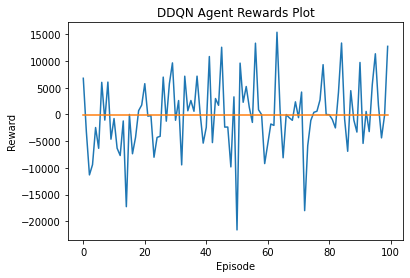

In [25]:
import matplotlib.pyplot as plt

reward_mean = [np.mean(agent.rewards_log)]*NUM_EPISODES

plt.plot(agent.rewards_log)
plt.plot(reward_mean)

plt.title('DDQN Agent Rewards Plot')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.show()

In [26]:
print('Average DDQN Agent Reward:', np.mean(agent.rewards_log))
print('Number of Games Won by DDQN Agent:', (agent.rewards_log > 0).sum(), '/', NUM_EPISODES)

Average DDQN Agent Reward: -125.0
Number of Games Won by DDQN Agent: 44 / 100


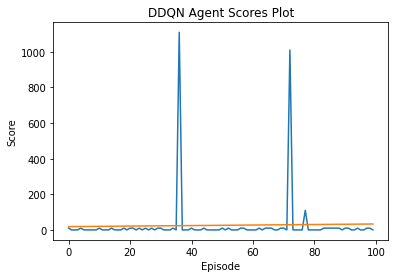

In [27]:
m, b = np.polyfit(np.arange(NUM_EPISODES), agent.scores_log, 1)

plt.plot(agent.scores_log)
plt.plot(np.arange(NUM_EPISODES), m*np.arange(NUM_EPISODES) + b)

plt.title('DDQN Agent Scores Plot')
plt.xlabel('Episode')
plt.ylabel('Score')

plt.show()